# Construct postage stamps for PSF explanation #

Started 2016-07-07 (WIC)

**Purpose:** Flexibly cut out postage stamps around (faint, medium, bright) stars in an HLA image.

**Eventual learning goal:** Gain practice in understanding a regime where visual appearance of objects differs from our own everyday experience.

# Setup #

In [2]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/Users/clarkson/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
from matplotlib import rcParams

In [5]:
plt.style.use('ggplot')

In [6]:
%matplotlib inline

In [7]:
rcParams['figure.figsize'] = (13, 7)

### Some control variables ###

In [8]:
# where are the image and star files located?
imgDir = os.getcwd()
txtDir = os.getcwd()

In [9]:
# image filename
imgFil = 'hlsp_heritage_hst_acs-wfc_m51_f435w_v1_drz_drz.fits'

In [10]:
# textfile with star coords. Comment "#" -- just x, y entries
txtFil = 'stars.txt'

In [40]:
# stamp-width
stampSz = [50,50]

# Load and examine image, stars #

In [41]:
imgPath = '%s/%s' % (imgDir, imgFil)
txtPath = '%s/%s' % (txtDir, txtFil)

In [42]:
# load the image
aImg = fits.getdata(imgPath)
print np.shape(aImg)

(12200, 8600)


In [43]:
# load the stars
tStars = Table.read(txtPath, format='ascii')
print tStars

  X      Y   
------ ------
6437.0 4960.0
6268.0 4821.0
6349.0 4823.0


### A little info for the plots ### 

In [52]:
fig = plt.figure(1, figsize=(13,5))

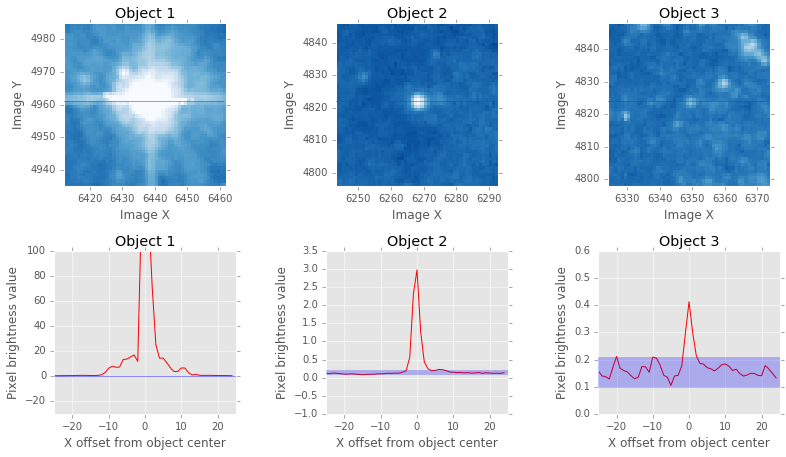

In [56]:
cmap = plt.cm.get_cmap('Blues_r')
plt.clf()

# colors for line and noise
cLine = 'r'
cNoise = 'b'

# give some space between the plots
plt.subplots_adjust(hspace=0.4, wspace=0.5)

for iPatch in range(len(tStars)):

    # set the postage stamp array
    xc = tStars['X'][iPatch]
    yc = tStars['Y'][iPatch]
    
    iLo = int(xc - 0.5*stampSz[0])
    iHi = int(xc + 0.5*stampSz[0])
    jLo = int(yc - 0.5*stampSz[1])
    jHi = int(yc + 0.5*stampSz[1])

    # take a cut through
    vCut = aImg[int(yc+1), iLo:iHi]
    lCut = np.arange(np.size(vCut))+iLo
    
    # postage stamp
    plt.subplot(2, len(tStars), iPatch+1)    
    extent=[iLo, iHi, jLo, jHi]
    plt.imshow(aImg[jLo:jHi, iLo:iHi], \
               norm=LogNorm(), \
               interpolation='None', \
              cmap=cmap, vmin=0.05, vmax=3., origin='lower', zorder=1, \
              extent=extent)
    plt.plot(lCut, np.repeat(yc+1, np.size(lCut)), zorder=5 ,color=cLine, alpha=0.5)
    plt.xlim(iLo, iHi)
    plt.ylim(jLo, jHi)
    plt.xlabel('Image X')
    plt.ylabel('Image Y')
    #plt.colorbar()
    plt.title('Object %i' % (iPatch+1))
    
    # spatial cut. Some awkwardness in the way the horizontal axis is defined
    plt.subplot(2, len(tStars), iPatch + 1 + len(tStars))
    plt.plot(lCut-xc, vCut, color=cLine)

    # some custom limits to make this stand out a little better
    yLos = [-30., -1.0, 0.]
    yHis = [100., 3.5, 0.6]
    plt.ylim(yLos[iPatch], yHis[iPatch])
    plt.xlim(iLo-xc, iHi-xc)
    
    # filler for "noise" level
    alphaPoly = 0.25
    if iPatch < 1:
        alphaPoly = 0.85
    xPoly = np.array([iLo, iHi, iHi, iLo, iLo])-xc
    yPoly = np.array([0.1, 0.1, 0.21, 0.21, 0.1])
    plt.fill(xPoly, yPoly, zorder=10, alpha=alphaPoly, color=cNoise)

    plt.xlabel('X offset from object center')
    plt.ylabel('Pixel brightness value')
    plt.title('Object %i' % (iPatch+1))

